# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../cifar-10-python.tar.gz to ../
Files already downloaded and verified


# Train model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [4]:
# Select device
device = torch.device('cuda')

In [5]:
# Check for model
if os.path.isfile('cifar resnet.pt'):
    # Load saved model
    print('Loading saved model')
    model = torch.load('cifar resnet.pt').to(device)

else:
    # Create model
    model = ResNet18(num_classes=10).to(device)

    # Training parameters
    lr = 1e-3
    mbsize = 256  # 16
    max_nepochs = 20
    loss_fn = nn.CrossEntropyLoss()
    lookback = 10
    verbose = True

    # Validation function
    val_loader = DataLoader(val_set, batch_size=mbsize, shuffle=False, num_workers=4)

    def validate(model):
        n = 0
        mean_loss = 0
        mean_acc = 0

        for x, y in val_loader:
            # Move to GPU.
            n += len(x)
            x = x.to(device)
            y = y.to(device)

            # Get predictions.
            pred = model(x)

            # Update loss.
            loss = loss_fn(pred, y).item()
            mean_loss += len(x) * (loss - mean_loss) / n

            # Update accuracy.
            acc = (torch.argmax(pred, dim=1) == y).float().mean().item()
            mean_acc += len(x) * (acc - mean_acc) / n

        return mean_loss, mean_acc

    # Data loader
    train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True,
                              drop_last=True, num_workers=4)

    # Setup
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=lookback // 2, min_lr=1e-5,
        mode='max', verbose=verbose)
    loss_list = []
    acc_list = []
    min_criterion = np.inf
    min_epoch = 0

    # Train
    for epoch in range(max_nepochs):
        for x, y in tqdm(train_loader, desc='Training loop', leave=True):
            # Move to device.
            x = x.to(device=device)
            y = y.to(device=device)

            # Take gradient step.
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # Check progress.
        with torch.no_grad():
            # Calculate validation loss.
            model.eval()
            val_loss, val_acc = validate(model)
            model.train()
            if verbose:
                print('----- Epoch = {} -----'.format(epoch + 1))
                print('Val loss = {:.4f}'.format(val_loss))
                print('Val acc = {:.4f}'.format(val_acc))
            loss_list.append(val_loss)
            acc_list.append(val_acc)
            scheduler.step(val_acc)

            # Check convergence criterion.
            val_criterion = - val_acc
            if val_criterion < min_criterion:
                min_criterion = val_criterion
                min_epoch = epoch
                best_model = deepcopy(model)
                print('')
                print('New best epoch, acc = {:.4f}'.format(val_acc))
                print('')
            elif (epoch - min_epoch) == lookback:
                if verbose:
                    print('Stopping early')
                break

    # Keep best model
    model = best_model
    
    # Save model
    model.cpu()
    torch.save(model, 'cifar resnet.pt')
    model.to(device)

Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 1.7024
Val acc = 0.4786

New best epoch, acc = 0.4786



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Traceback (most recent call last):
        self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/

Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

    self._shutdown_workers()
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


----- Epoch = 2 -----
Val loss = 1.2463
Val acc = 0.6157

New best epoch, acc = 0.6157



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 0.9514
Val acc = 0.6865

New best epoch, acc = 0.6865



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 0.7803
Val acc = 0.7368

New best epoch, acc = 0.7368



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 0.8065
Val acc = 0.7370

New best epoch, acc = 0.7370



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 0.5703
Val acc = 0.8085

New best epoch, acc = 0.8085



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most 

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()        Exception ignored in: 
if w.is_alive():if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers



  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
              File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'


      File "/home-nfs/raphaelr/miniconda/lib/py

----- Epoch = 7 -----
Val loss = 0.4785
Val acc = 0.8376

New best epoch, acc = 0.8376



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>




Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignor



  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

:   File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
          File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
can only test a child process    assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'    
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

Exception ignored in: AssertionError: 
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.p

----- Epoch = 8 -----
Val loss = 0.4315
Val acc = 0.8545

New best epoch, acc = 0.8545



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 0.4374
Val acc = 0.8572

New best epoch, acc = 0.8572



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 0.4318
Val acc = 0.8579

New best epoch, acc = 0.8579



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 0.4576
Val acc = 0.8527


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 0.4718
Val acc = 0.8506


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 0.3823
Val acc = 0.8773

New best epoch, acc = 0.8773



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>

AssertionErrorTraceback (most recent call last):
:   File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
can only test a child process
    self._shutdown_workers()
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/

self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
self._shutdown_workers()

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
        if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multipro


  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
        if w.is_alive():    Exception ignored in: if w.is_alive():
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive


  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
          File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    assert self._parent_pid == os.getpid(), 'c

----- Epoch = 14 -----
Val loss = 0.5023
Val acc = 0.8498


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    Exception ignored in: Exception ignored in: Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>



  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", lin


Traceback (most recent call last):

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        
if w.is_alive():self._shutdown_workers()
      File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():    AssertionError: 



      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
    
      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():AssertionErrorif w.is_alive():
: 
      File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
can only test a child process  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
    
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
assert se

AssertionErrorif w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process': 

      File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
can only test a child processAssertionErrorassert self._parent_pid == os.getpid(), 'can only test a child process'
: 
    can only test a child processAssertionErrorassert self._parent_pid == os.getpid(), 'can only test a child process'
: 
can only test a child processAssertionError
: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>Traceback (most recent call last):

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


----- Epoch = 15 -----
Val loss = 0.4005
Val acc = 0.8752


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>




Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-n




    Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
        if w.is_alive():  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()self._shutdown_workers()

    
      File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
    
self._shutdown_workers() 

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
    Traceback (most recent call last):

AssertionErrorif w.is_alive():  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):

:       File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        if w.is_alive():  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()self._shutdown_workers()can only test a child process



  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in 

----- Epoch = 16 -----
Val loss = 0.3972
Val acc = 0.8728


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 0.3843
Val acc = 0.8769


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 0.4464
Val acc = 0.8702


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 0.4846
Val acc = 0.8622
Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 0.3331
Val acc = 0.9021

New best epoch, acc = 0.9021



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 0.3274
Val acc = 0.9061

New best epoch, acc = 0.9061



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 0.3278
Val acc = 0.9105

New best epoch, acc = 0.9105



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
                self

Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
: can only test a child process            
self._shutdown_workers()self._shutdown_workers()
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>    if w.is_alive():if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    
assert 

      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
if w.is_alive():  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    
        if w.is_alive():  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

    
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError
    :     AssertionErrorassert self._parent_pid == os.getpid(), 'can only te

----- Epoch = 23 -----
Val loss = 0.4349
Val acc = 0.8881


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>

Traceback (most recent call last):
Exception ignored in: Exception ignored in: Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    
Traceback (most recent call last):
    self._shutdown_workers()Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/da

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
can only test a child process        

assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

AssertionErrorException ignored in:   File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>    :     if w.is_alive():
can only test a child processassert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>

  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiproce

    AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>can only test a child process
AssertionErrorif w.is_alive():: can only test a child process
    
: 
can only test a child process
Traceback (most recent call last):
self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
can only test a child process  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__



Exception ignored in:       File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>Exception ignored in:     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>    self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
if w.is_alive():Traceback (most rec

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

Traceback (most recent call last):
          File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()self._shutdown_workers()

      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
self._shutdown_workers()
          File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():if w.is_alive():

      File "/home-

: 
can only test a child process  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

    Exception ignored in: AssertionErrorException ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>
: 

AssertionErrorcan only test a child processTraceback (most recent call last):
Traceback (most recent call last):
: 
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
can only test a child process
        

----- Epoch = 24 -----
Val loss = 0.3719
Val acc = 0.9046


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()


  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3


Traceback (most recent call last):
AssertionError      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
: assert self._parent_pid == os.getpid(), 'can only test a child process'can only test a child processException ignored in:     
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f245638d160>AssertionErrorassert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
: 

Traceback (most recent call last):
can only test a child processAssertionError
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

:     can only test a child process    
if w.is_alive():self._shutdown_workers()Exception ignored in: 
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f

AssertionError  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()self._shutdown_workers()can only test a child process: 


can only test a child process      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

self._shutdown_workers()  File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():if w.is_alive():
    
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home-nfs/raphaelr/miniconda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child pr

----- Epoch = 25 -----
Val loss = 0.3397
Val acc = 0.9097


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 0.3806
Val acc = 0.9030


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 0.3804
Val acc = 0.9061


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 0.3682
Val acc = 0.9128

New best epoch, acc = 0.9128



Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 0.3808
Val acc = 0.9059


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 0.4083
Val acc = 0.9020


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 0.3849
Val acc = 0.9110


Training loop:   0%|          | 0/195 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Train surrogate

In [6]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [7]:
# Check for model
if os.path.isfile('cifar surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('cifar surrogate.pt').to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

else:
    # Create model
    surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)

    # Set up surrogate object
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)
    
    # Set up datasets
    train_surr = DatasetInputOnly(train_set)
    val_surr = DatasetInputOnly(val_set)
    original_model = nn.Sequential(model, nn.Softmax(dim=1))

    # Train
    surrogate.train_original_model(
        train_surr,
        val_surr,
        original_model,
        batch_size=20,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save surrogate
    surr.cpu()
    torch.save(surr, 'cifar surrogate.pt')
    surr.to(device)

Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 1.5375

New best epoch, loss = 1.5375



Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 1.2486

New best epoch, loss = 1.2486



Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 1.1068

New best epoch, loss = 1.1068



Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 1.0457

New best epoch, loss = 1.0457



Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 0.9188

New best epoch, loss = 0.9188



Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 0.9323



Training epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Train FastSHAP

In [8]:
from unet import UNet
from fastshap import FastSHAP

In [9]:
# Check for model
if os.path.isfile('cifar explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'cifar explainer.pt')
    explainer.to(device)

Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 1950.844604

New best epoch, loss = 1950.844604



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 1644.158691

New best epoch, loss = 1644.158691



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 1511.727905

New best epoch, loss = 1511.727905



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 1334.768555

New best epoch, loss = 1334.768555



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 1191.157471

New best epoch, loss = 1191.157471



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 1055.319458

New best epoch, loss = 1055.319458



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 1054.938599

New best epoch, loss = 1054.938599



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Visualize results

In [10]:
import matplotlib.pyplot as plt

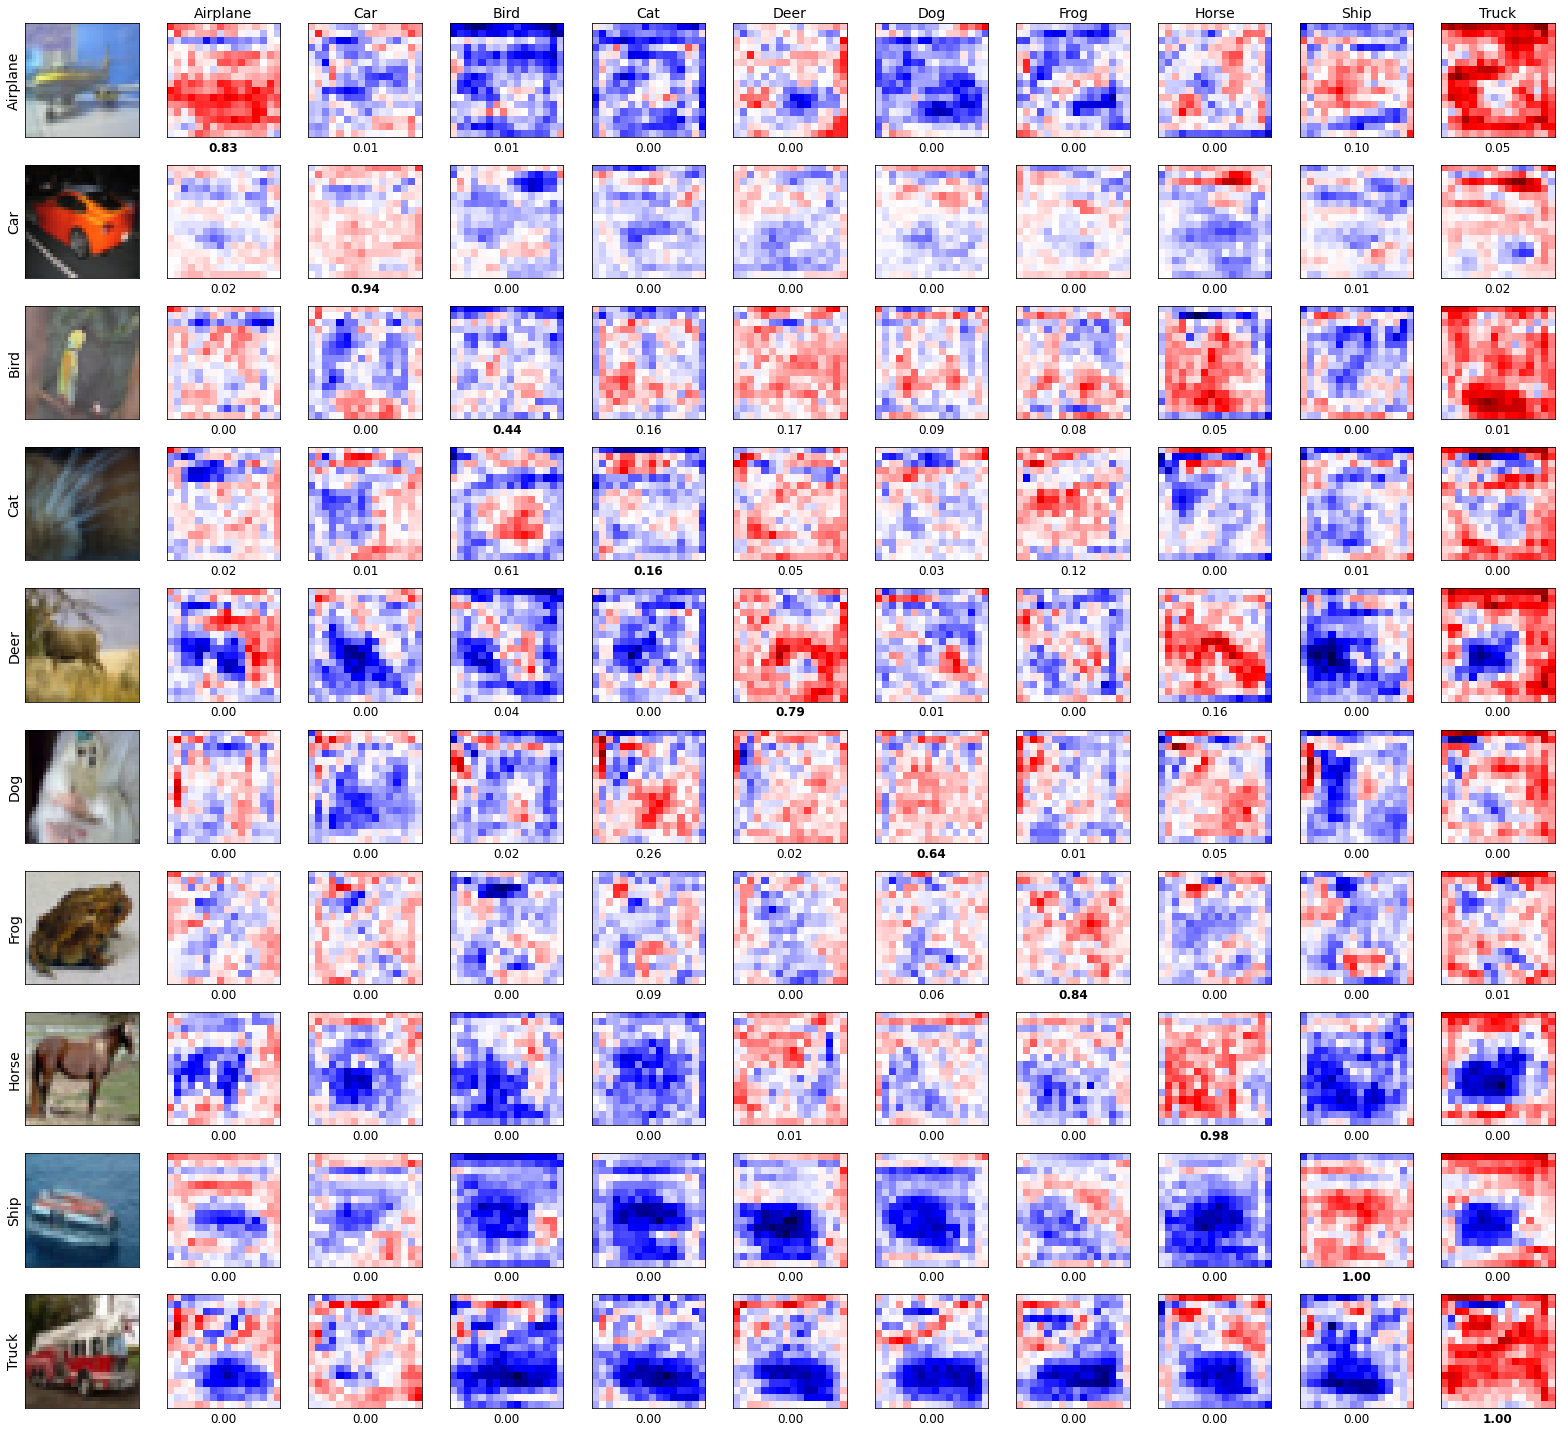

In [11]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()

In [19]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

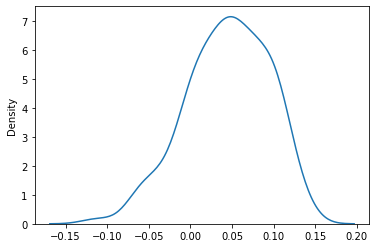

In [21]:
sns.kdeplot(values[0,0,:,:].reshape(-1))